This notebook can be used to load raw ultraleap data, 
save cleaned dataframes for each block, 
and generate dataframes of distances for further feature extraction

Import public packages and functions

In [1]:
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import compress
import seaborn as sn

import openpyxl
from datetime import datetime
from scipy.spatial import distance
from scipy.ndimage import uniform_filter1d
import math
from scipy.signal import find_peaks, peak_prominences
import statistics as stat
import json
import traces

In [2]:
def get_repo_path_in_notebook():
    """
    Finds path of repo from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()
    repo_name = 'ultraleap_analysis'

    while path[-len(repo_name):] != 'ultraleap_analysis':

        path = os.path.dirname(path)

    return path


In [3]:
repo_path = get_repo_path_in_notebook()
code_path = os.path.join(repo_path, 'code')
os.chdir(code_path)

Import own functions

In [4]:
import import_data.import_and_convert_data as import_dat
import import_data.find_paths as find_paths
import import_data.preprocessing_meta_info as meta_info
import sig_processing.segment_tasks as seg_tasks
import movement_calc.helpfunctions as hp
import feature_extraction.get_features as get_feat
import feature_extraction.get_files as get_files

### Saving blocks for preprocessing

Reloading own functions

In [5]:
importlib.reload(import_dat)
importlib.reload(seg_tasks)
importlib.reload(find_paths)
importlib.reload(meta_info)
importlib.reload(hp)
importlib.reload(get_feat)
importlib.reload(get_files)

<module 'feature_extraction.get_files' from '/Users/arianm/Documents/GitHub/ultraleap_analysis/code/feature_extraction/get_files.py'>

Define variables of interest

In [6]:
folder = 'patientdata'
conds = ['m1', 'm0s0', 'm0s1', 'm1s0', 'm1s1']
cams = ['dt', 'vr',  'st']
tasks = ['ft', 'oc', 'ps', 'pt']
sides = ['left', 'right']
subs = find_paths.find_available_subs(folder)
subs.sort()

Save blocks for feature extraction 

In [15]:
for sub in subs:
    for cond in conds:
        for cam in cams:
            for task in tasks:
                for side in sides:
                    # get defined data
                    try:
                        data = import_dat.get_data(folder = folder,
                            sub=sub, cam_pos=cam, task=task, side=side, condition= cond
                        )
                        
                        # get block dataframes
                        blocks = seg_tasks.block_extraction(
                            data, sub=sub, task=task, side=side, cond= cond,
                            cam=cam, to_save=True)
                        
                        block_path = os.path.join(
                            repo_path, 'data', 'raw_blocks', folder, sub, task)

                    except Exception:
                        continue

                    #saving blocks as .csv files
                    for block in blocks.keys():
                        if blocks[block].empty:
                            continue
                        if not os.path.exists(block_path) and not blocks[block].empty:
                            os.makedirs(block_path)
                            
                        blocks[block].to_csv(os.path.join(
                            block_path, f'{block}_{sub}_{cond}_{cam}_{task}_{side}.csv'))

Load blocks, calculate distances and create dist-time .csv files

In [ ]:
for sub in subs:
    for task in tasks:
        try:
            files = os.listdir(os.path.join(repo_path, 'data','raw_blocks', folder, sub, task))

        except FileNotFoundError:
            continue 
        
        for file in files:
            if file == '.DS_Store':
                continue

            # Load blocks from patients' blocks dir
            block = pd.read_csv(os.path.join(
                repo_path, 'data', 'raw_blocks', folder, sub, task, file))

            if task == 'oc':
                dist = hp.calc_distances(block, 'middle_tip', 'palm')
            elif task == 'ft':
                dist = hp.calc_distances(block, 'index_tip', 'thumb_tip')
            elif task == 'ps':
                dist = hp.calc_prosup_angle(block, 'thumb_tip', 'middle_tip', 'palm')
            elif task == 'pt':
                continue
            
            dist['time'] = block.program_time.to_list()


            dist_path = os.path.join(repo_path, 'data', 'distances', folder ,sub, task)

            if not os.path.exists(dist_path): os.makedirs(dist_path)

            dist.to_csv(os.path.join(dist_path, f'dist_{file}'))

# Visualisations for self-control

In [32]:
for sub in subs:
    for task in tasks:
        try:
            files = os.listdir(os.path.join(repo_path, 'data','distances', folder, sub, task))

        except FileNotFoundError:
            continue 
        
        for file in files:

            if file == '.DS_Store':
                continue

            # Load blocks from patients' blocks dir
            block = pd.read_csv(os.path.join(
                repo_path, 'data', 'distances', folder, sub, task, file), index_col= 0)
            

In [ ]:
def new( x ):
    '''
    Playground
    '''

    ...

    # plt.figure(figsize=(18, 10))
    # plt.plot(dist_array)
    # plt.plot(dist_dataframe.iloc[ ].iloc[:,0], 'o', color= 'red')
    # plt.plot(dist_dataframe.iloc[ ].iloc[:,0], 'o', color= 'blue')
    # plt.show()
    return

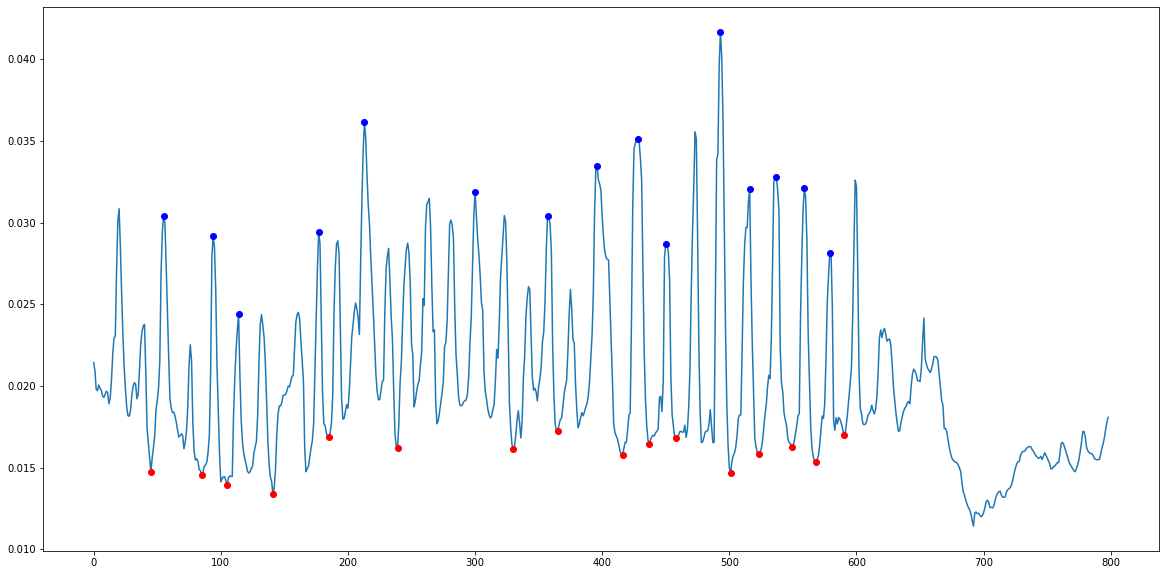

In [39]:
df = pd.read_csv('/Users/arianm/Documents/GitHub/ultraleap_analysis/data/distances/patientdata/ul009/ft/dist_b1_ul009_m1_st_ft_right.csv', index_col= 0)
x, y = hp.find_min_max(df, 'ft')

plt.figure(figsize=(20, 10))
plt.plot(df.iloc[:, 0])
plt.plot(df.iloc[x].iloc[:,0], 'o', color= 'red')
plt.plot(df.iloc[y].iloc[:,0], 'o', color= 'blue')
plt.show()

Correlation matrix

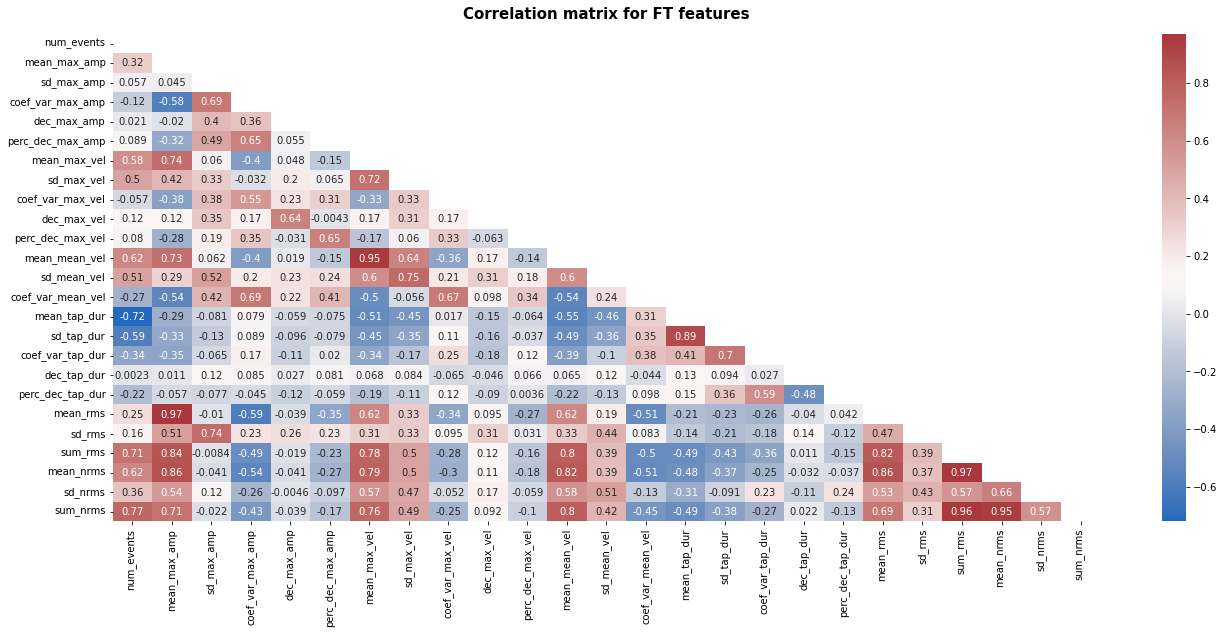

In [9]:
df = pd.read_csv('/Users/arianm/Documents/GitHub/ultraleap_analysis/data/features/dataframes/patientdata/ft_block_features.csv', index_col= 0)
corr_matrix = df.corr()
matrix = np.triu(corr_matrix)
plt.figure(figsize=(20, 10))
plt.title('Correlation matrix for FT features',  pad=15, weight = 'bold', fontsize = 15)

sn.heatmap(corr_matrix, annot=True, mask=matrix, cmap="vlag")
fname = 'heatmap_ft_feat'
plt.tight_layout( pad = 5)
plt.savefig(
    os.path.join(
        '/Users/arianm/Documents/GitHub/ultraleap_analysis/figures/', fname
    ),
    dpi=300,
    facecolor='w',
)

plt.show()